In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import os
import glob
import re
import seaborn as sns
from tqdm.notebook import tqdm
from scipy.stats import pearsonr
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from transformers import TFBertForSequenceClassification, BertTokenizer, AutoTokenizer, TFAutoModelForSequenceClassification
import tensorflow as tf

import sys
sys.path.append("..")
import utils.utils as utils
import utils.postprocessing_utils as post_utils
from data_preparation.data_preparation_sentiment import Example, convert_examples_to_tf_dataset, make_batches

#<img src="attachment:image.png" width="300" height="300" align="left">
"""
<hr>
<a id=""></a>

[Back to contents](#index)
""";

<a id="index"></a>

[A.1. Transfer Loss](#A1)

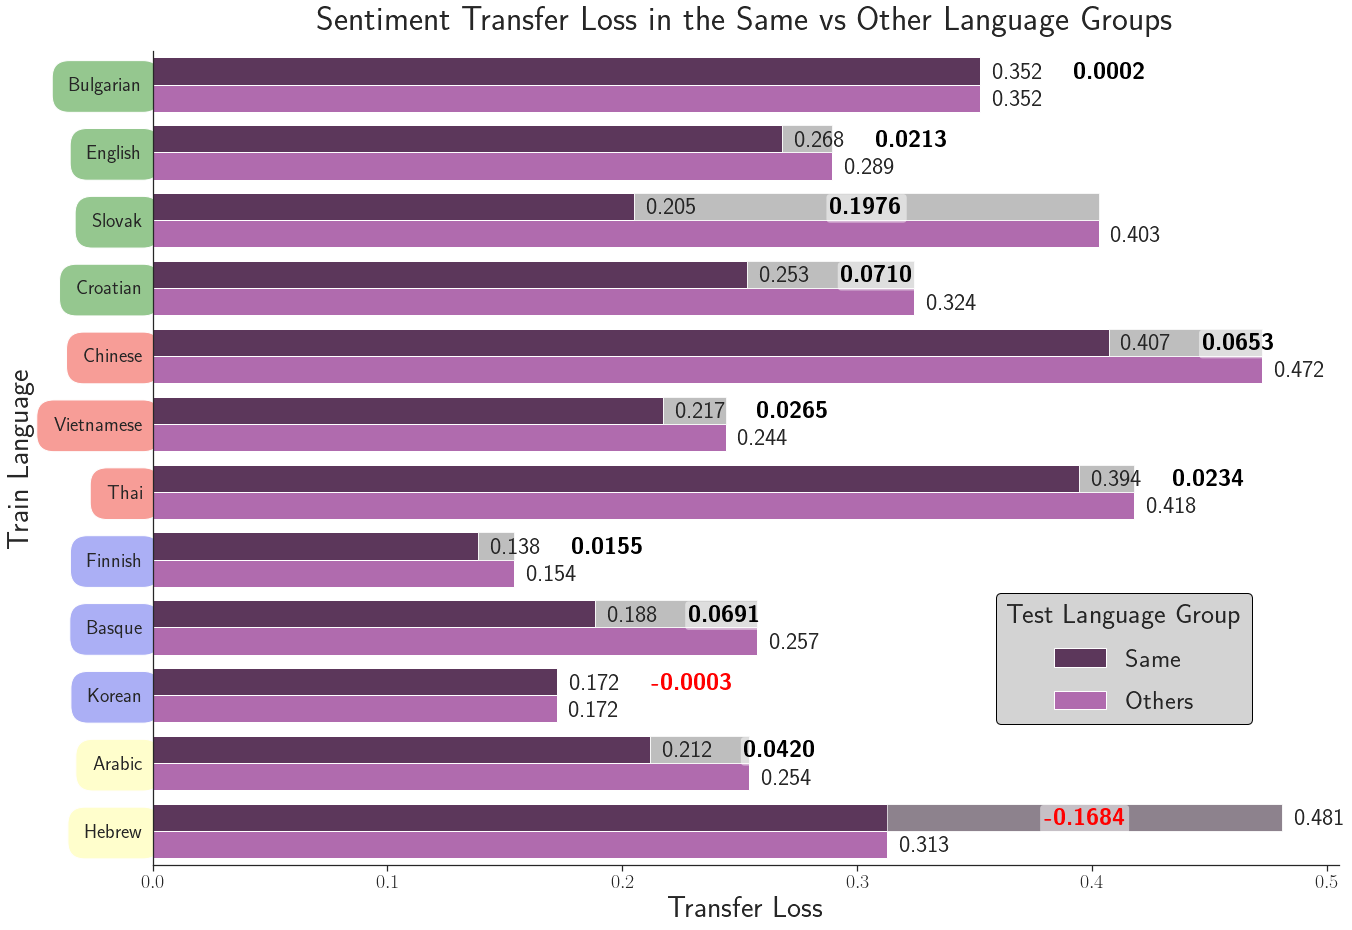

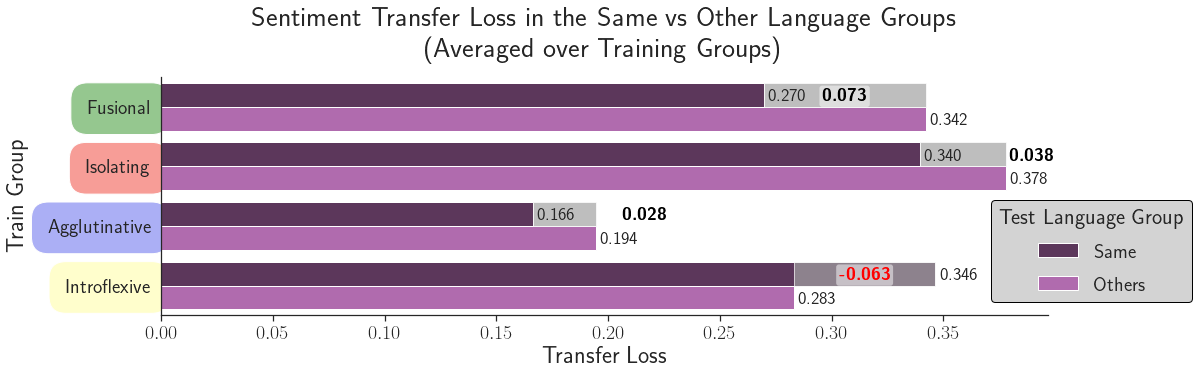

<hr>
<a id="A1"></a>

[Back to contents](#index)

### A.1. Transfer Loss

In [268]:
results = post_utils.retrieve_results("../results/results_sentiment_postprocessed.xlsx", 3)
langvlang = results["Macro_F1"]["langvlang"]
langvgroup = results["Macro_F1"]["langvgroup"]

In [270]:
df = pd.DataFrame({"Train-Group": langvlang.iloc[:12, 0], "Train-Language": langvlang.columns[2:-1], 
                   "Within-Macro-F1": np.diagonal(langvlang.iloc[:12, 2:-1].values)})

In [274]:
df_group = langvgroup.iloc[:4, [True, False] + [True] * 12 + [False]]

In [275]:
df_group = pd.melt(df_group.rename(columns={"Test\Train": "Test-Group"}), id_vars="Test-Group", 
                   value_vars=df_group.columns[1:], 
                   var_name="Train-Language", value_name="Cross-Macro-F1")

In [276]:
transfer = pd.merge(df, df_group, on="Train-Language")
transfer["Cross-Macro-F1"] = transfer["Cross-Macro-F1"].astype(float)
transfer["Within-Macro-F1"] = transfer["Within-Macro-F1"].astype(float)

In [277]:
transfer["Transfer-Loss"] = transfer["Within-Macro-F1"] - transfer["Cross-Macro-F1"]

In [278]:
final = transfer[transfer["Test-Group"] != transfer["Train-Group"]].groupby(by=["Train-Group", "Train-Language"], 
                                                                    as_index=False, sort=False).mean()
final["Test-Group"] = "Others"

In [279]:
temp = transfer[transfer["Test-Group"] == transfer["Train-Group"]].copy()
temp.loc[:, "Test-Group"] = "Same"

In [281]:
final = pd.concat([final, temp], ignore_index=True)
final["sort"] = np.concatenate((np.arange(1, 24, 2), np.arange(0, 24, 2)))

In [283]:
final = final.sort_values("sort").reset_index(drop=True).drop("sort", axis=1)

In [285]:
sns.set()
sns.set_style("ticks")
plt.rc("xtick", labelsize=16)
plt.rc("ytick", labelsize=16)
plt.rc("axes", labelsize=16)
plt.rcParams["text.usetex"] = True

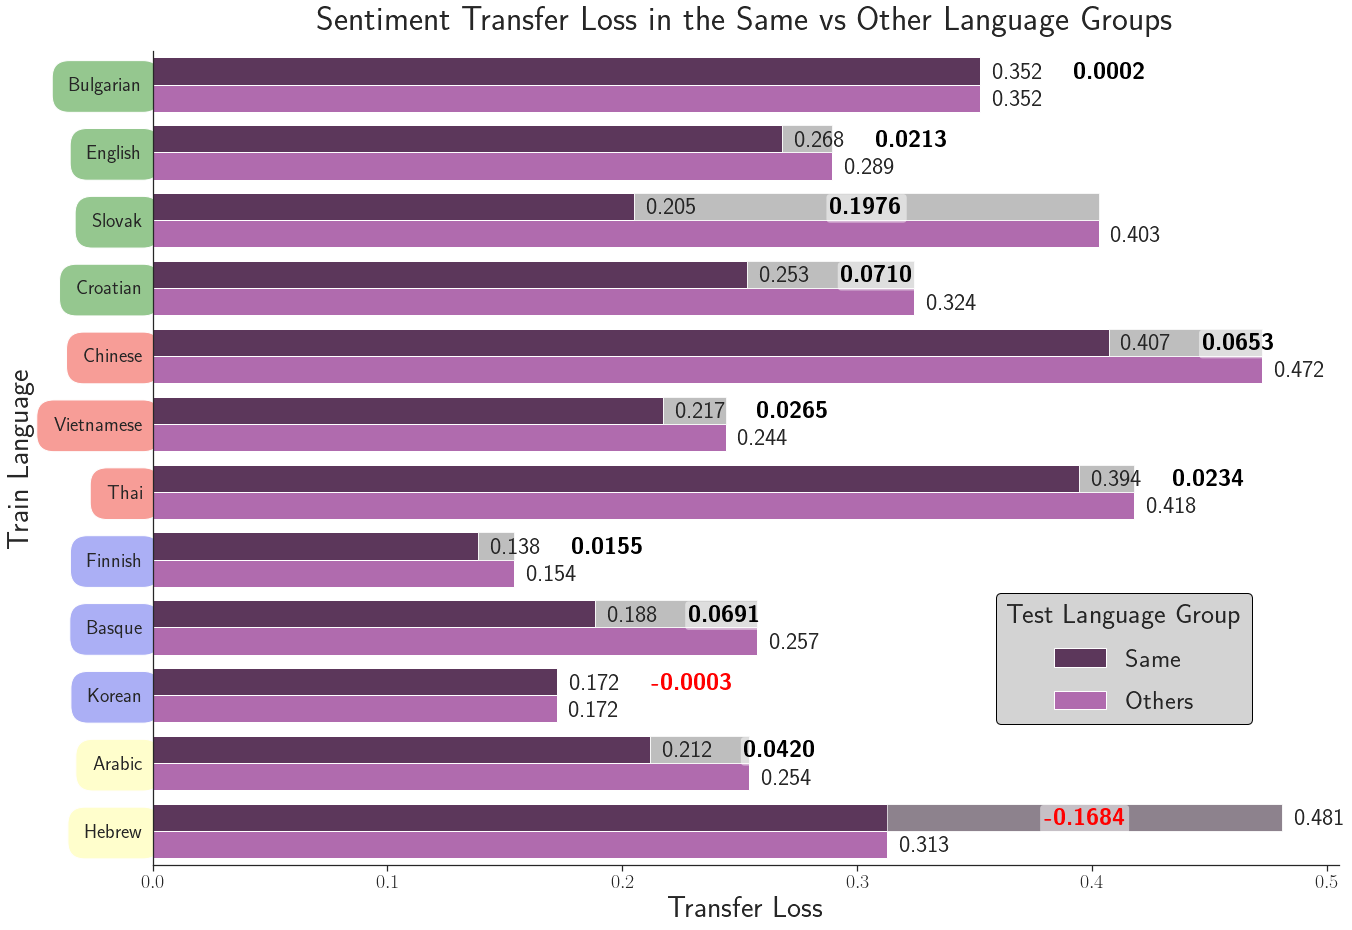

In [315]:
def scale_y(y, langs):
    return 1 - y / len(langs)

colors = ["#95c78f", "#f79d97", "#abaff5", "#fffecc"]
bar_colors = {"Same": "#870c85", "Others": "#ff1cfb"}
label_colors = np.array([np.repeat(color, times).tolist() for color, times in zip(colors, [4, 3, 3, 2])]).sum()
extra_fontsize = 6

g = sns.catplot(
    data=final, kind="bar", x="Transfer-Loss", y="Train-Language", hue="Test-Group",
    height=12, aspect=1.5, palette=bar_colors, saturation=0.3, legend=False
)

langs = final["Train-Language"].unique().tolist()

for lang in langs:
    values = final.loc[(final["Train-Language"] == lang), "Transfer-Loss"].values
    dy = [-0.2, 0.2]
    for i, idx in enumerate(final.index[final["Train-Language"] == lang]):
        p = "{:.3f}".format(values[i])
        extra_dy = 0.025
        g.ax.text(values[i] + 0.005, langs.index(lang) + dy[i] + extra_dy, p, 
                  verticalalignment="center", horizontalalignment="left", 
                  fontsize=18 + extra_fontsize)
        
    # Difference bar
    bbar = patches.Rectangle((values[0], langs.index(lang) + dy[i] - 0.2), values[1] - values[0], -0.4, 
                          fill=True, color="#a3a3a3", alpha=0.7, ec=None)
    g.ax.add_patch(bbar)
    x = values.mean()
    align = "center"
    diff = values[1] - values[0]
    color = "black"
    if np.abs(diff) <= 0.1:
        align = "left"
        x = values[0] + 0.04
    if diff < 0:
        color = "red"
    g.ax.text(x, langs.index(lang) + dy[i] + extra_dy - 0.4, r"\textbf{{{:.4f}}}".format(diff), 
              verticalalignment="center", horizontalalignment=align, 
              fontsize=18 + extra_fontsize, color=color,
              bbox=dict(boxstyle="round, pad=0.15",
                                 fc=(1, 1, 1, 0.5),
                                 ec="none"))
        
for i, label in enumerate(g.ax.yaxis.get_ticklabels()):
    label.set_bbox(dict(boxstyle="round,pad=0.85",
                             fc=label_colors[i]))
        
plt.legend(title="Test Language Group", title_fontsize=22 + extra_fontsize, loc="upper left", 
           bbox_to_anchor=(0.7, 0.35), fontsize=20 + extra_fontsize, facecolor="lightgrey", 
           framealpha=1, edgecolor="black", labelspacing=0.7)

# plt.xlim((0, 51))
# plt.xticks(range(0, 51, 5))
plt.ylabel("Train Language", fontsize=24 + extra_fontsize, labelpad=20)
plt.xlabel("Transfer Loss", fontsize=24 +  extra_fontsize)
plt.title("Sentiment Transfer Loss in the Same vs Other Language Groups", fontsize=28 +  extra_fontsize, pad=20)
plt.tick_params(labelsize=20)

#plt.savefig("../results/plots/sentiment_transfer_loss_all.pdf", dpi=400, bbox_inches="tight")
plt.show()
plt.close()

In [298]:
final_avg = final.groupby(by=["Train-Group", "Test-Group"], as_index=False, sort=False).mean()

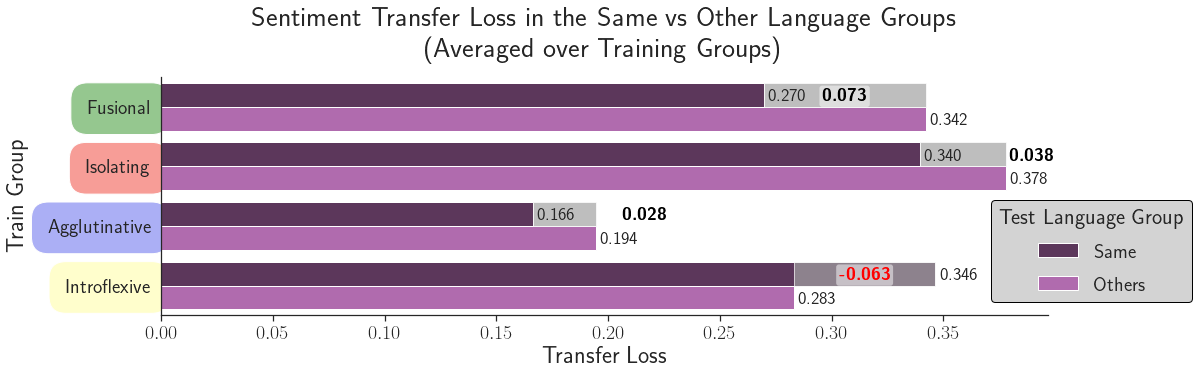

In [313]:
def scale_y(y, groups):
    return 1 - y / len(groups)

colors = ["#95c78f", "#f79d97", "#abaff5", "#fffecc"]
bar_colors = {"Same": "#870c85", "Others": "#ff1cfb"}
extra_fontsize = 0

g = sns.catplot(
    data=final_avg, kind="bar", x="Transfer-Loss", y="Train-Group", hue="Test-Group",
    height=4, aspect=3.5, palette=bar_colors, saturation=0.3, legend=False
)

groups = final_avg["Train-Group"].unique().tolist()

for group in groups:
    values = final_avg.loc[(final_avg["Train-Group"] == group), "Transfer-Loss"].values
    dy = [-0.2, 0.2]
    for i, idx in enumerate(final_avg.index[final_avg["Train-Group"] == group]):
        p = "{:.3f}".format(values[i])
        extra_dy = 0.025
        g.ax.text(values[i] + 0.002, groups.index(group) + dy[i] + extra_dy, p, 
                  verticalalignment="center", horizontalalignment="left", 
                  fontsize=18 + extra_fontsize)
        
    # Difference bar
    bbar = patches.Rectangle((values[0], groups.index(group) + dy[i] - 0.2), values[1] - values[0], -0.4, 
                          fill=True, color="#a3a3a3", alpha=0.7, ec=None)
    g.ax.add_patch(bbar)
    x = values.mean()
    align = "center"
    diff = values[1] - values[0]
    color = "black"
    if np.abs(diff) <= 0.05:
        align = "left"
        x = values[0] + 0.04
    if diff < 0:
        color = "red"
    g.ax.text(x, groups.index(group) + dy[i] + extra_dy - 0.4, r"\textbf{{{:.3f}}}".format(diff), 
              verticalalignment="center", horizontalalignment=align, 
              fontsize=18 + extra_fontsize, color=color,
              bbox=dict(boxstyle="round, pad=0.15",
                                 fc=(1, 1, 1, 0.5),
                                 ec="none"))
        
for i, label in enumerate(g.ax.yaxis.get_ticklabels()):
    label.set_bbox(dict(boxstyle="round,pad=0.85",
                             fc=colors[i]))
        
plt.legend(title="Test Language Group", title_fontsize=22 + extra_fontsize, loc="upper left", 
           bbox_to_anchor=(0.925, 0.525), fontsize=20 + extra_fontsize, facecolor="lightgrey", 
           framealpha=1, edgecolor="black", labelspacing=0.7)

# plt.xlim((0, 51))
# plt.xticks(range(0, 51, 5))
plt.ylabel("Train Group", fontsize=24 + extra_fontsize, labelpad=20)
plt.xlabel("Transfer Loss", fontsize=24 +  extra_fontsize)
plt.title("Sentiment Transfer Loss in the Same vs Other Language Groups \n (Averaged over Training Groups)", 
          fontsize=28 + extra_fontsize, pad=20)
plt.tick_params(labelsize=20)

#plt.savefig("../results/plots/sentiment_transfer_loss_groups.pdf", dpi=400, bbox_inches="tight")
plt.show()
plt.close()

<hr>
<a id="A2"></a>

[Back to contents](#index)

### A.2. Balanced Length Transfer Loss

In [2]:
results = post_utils.retrieve_results("../results/balanced_length/results_sentiment_postprocessed_balanced_length.xlsx", 3)
langvlang = results["Macro_F1"]["langvlang"]
langvgroup = results["Macro_F1"]["langvgroup"]

In [3]:
df = pd.DataFrame({"Train-Group": langvlang.iloc[:12, 0], "Train-Language": langvlang.columns[2:-1], 
                   "Within-Macro-F1": np.diagonal(langvlang.iloc[:12, 2:-1].values)})

In [4]:
df_group = langvgroup.iloc[:4, [True, False] + [True] * 12 + [False]]

In [5]:
df_group = pd.melt(df_group.rename(columns={"Test\Train": "Test-Group"}), id_vars="Test-Group", 
                   value_vars=df_group.columns[1:], 
                   var_name="Train-Language", value_name="Cross-Macro-F1")

In [6]:
transfer = pd.merge(df, df_group, on="Train-Language")
transfer["Cross-Macro-F1"] = transfer["Cross-Macro-F1"].astype(float)
transfer["Within-Macro-F1"] = transfer["Within-Macro-F1"].astype(float)

In [7]:
transfer["Transfer-Loss"] = transfer["Within-Macro-F1"] - transfer["Cross-Macro-F1"]

In [8]:
final = transfer[transfer["Test-Group"] != transfer["Train-Group"]].groupby(by=["Train-Group", "Train-Language"], 
                                                                    as_index=False, sort=False).mean()
final["Test-Group"] = "Others"

In [9]:
temp = transfer[transfer["Test-Group"] == transfer["Train-Group"]].copy()
temp.loc[:, "Test-Group"] = "Same"

In [10]:
final = pd.concat([final, temp], ignore_index=True)
final["sort"] = np.concatenate((np.arange(1, 24, 2), np.arange(0, 24, 2)))

In [11]:
final = final.sort_values("sort").reset_index(drop=True).drop("sort", axis=1)

In [12]:
sns.set()
sns.set_style("ticks")
plt.rc("xtick", labelsize=16)
plt.rc("ytick", labelsize=16)
plt.rc("axes", labelsize=16)
plt.rcParams["text.usetex"] = True

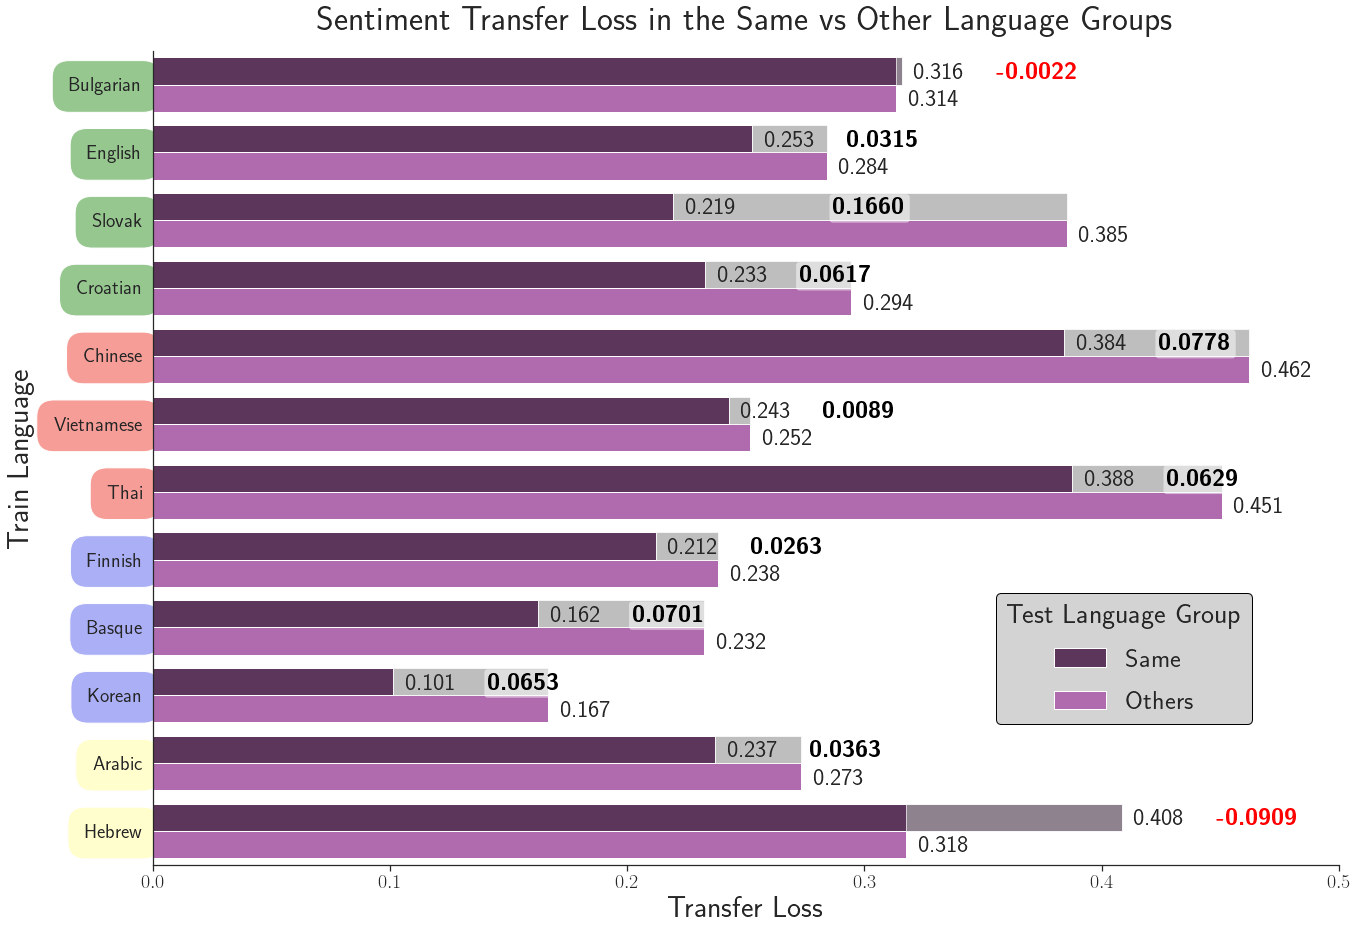

In [13]:
def scale_y(y, langs):
    return 1 - y / len(langs)

colors = ["#95c78f", "#f79d97", "#abaff5", "#fffecc"]
bar_colors = {"Same": "#870c85", "Others": "#ff1cfb"}
label_colors = np.array([np.repeat(color, times).tolist() for color, times in zip(colors, [4, 3, 3, 2])]).sum()
extra_fontsize = 6

g = sns.catplot(
    data=final, kind="bar", x="Transfer-Loss", y="Train-Language", hue="Test-Group",
    height=12, aspect=1.5, palette=bar_colors, saturation=0.3, legend=False
)

langs = final["Train-Language"].unique().tolist()

for lang in langs:
    values = final.loc[(final["Train-Language"] == lang), "Transfer-Loss"].values
    dy = [-0.2, 0.2]
    for i, idx in enumerate(final.index[final["Train-Language"] == lang]):
        p = "{:.3f}".format(values[i])
        extra_dy = 0.025
        g.ax.text(values[i] + 0.005, langs.index(lang) + dy[i] + extra_dy, p, 
                  verticalalignment="center", horizontalalignment="left", 
                  fontsize=18 + extra_fontsize)
        
    # Difference bar
    bbar = patches.Rectangle((values[0], langs.index(lang) + dy[i] - 0.2), values[1] - values[0], -0.4, 
                          fill=True, color="#a3a3a3", alpha=0.7, ec=None)
    g.ax.add_patch(bbar)
    x = values.mean()
    align = "center"
    diff = values[1] - values[0]
    color = "black"
    if np.abs(diff) <= 0.1:
        align = "left"
        x = values[0] + 0.04
    if diff < 0:
        color = "red"
    g.ax.text(x, langs.index(lang) + dy[i] + extra_dy - 0.4, r"\textbf{{{:.4f}}}".format(diff), 
              verticalalignment="center", horizontalalignment=align, 
              fontsize=18 + extra_fontsize, color=color,
              bbox=dict(boxstyle="round, pad=0.15",
                                 fc=(1, 1, 1, 0.5),
                                 ec="none"))
        
for i, label in enumerate(g.ax.yaxis.get_ticklabels()):
    label.set_bbox(dict(boxstyle="round,pad=0.85",
                             fc=label_colors[i]))
        
plt.legend(title="Test Language Group", title_fontsize=22 + extra_fontsize, loc="upper left", 
           bbox_to_anchor=(0.7, 0.35), fontsize=20 + extra_fontsize, facecolor="lightgrey", 
           framealpha=1, edgecolor="black", labelspacing=0.7)

plt.xlim((0, 0.5))
# plt.xticks(range(0, 51, 5))
plt.ylabel("Train Language", fontsize=24 + extra_fontsize, labelpad=20)
plt.xlabel("Transfer Loss", fontsize=24 +  extra_fontsize)
plt.title("Sentiment Transfer Loss in the Same vs Other Language Groups", fontsize=28 +  extra_fontsize, pad=20)
plt.tick_params(labelsize=20)

#plt.savefig("../results/plots/sentiment_transfer_loss_all.pdf", dpi=400, bbox_inches="tight")
plt.show()
plt.close()

In [14]:
final_avg = final.groupby(by=["Train-Group", "Test-Group"], as_index=False, sort=False).mean()

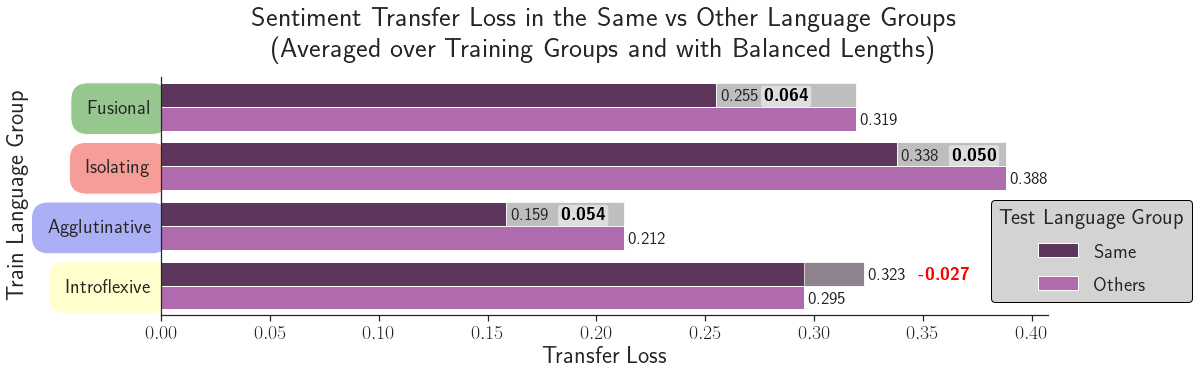

In [25]:
def scale_y(y, groups):
    return 1 - y / len(groups)

colors = ["#95c78f", "#f79d97", "#abaff5", "#fffecc"]
bar_colors = {"Same": "#870c85", "Others": "#ff1cfb"}
extra_fontsize = 0

g = sns.catplot(
    data=final_avg, kind="bar", x="Transfer-Loss", y="Train-Group", hue="Test-Group",
    height=4, aspect=3.5, palette=bar_colors, saturation=0.3, legend=False
)

groups = final_avg["Train-Group"].unique().tolist()

for group in groups:
    values = final_avg.loc[(final_avg["Train-Group"] == group), "Transfer-Loss"].values
    dy = [-0.2, 0.2]
    for i, idx in enumerate(final_avg.index[final_avg["Train-Group"] == group]):
        p = "{:.3f}".format(values[i])
        extra_dy = 0.025
        g.ax.text(values[i] + 0.002, groups.index(group) + dy[i] + extra_dy, p, 
                  verticalalignment="center", horizontalalignment="left", 
                  fontsize=18 + extra_fontsize)
        
    # Difference bar
    bbar = patches.Rectangle((values[0], groups.index(group) + dy[i] - 0.2), values[1] - values[0], -0.4, 
                          fill=True, color="#a3a3a3", alpha=0.7, ec=None)
    g.ax.add_patch(bbar)
    x = values.mean()
    align = "center"
    diff = values[1] - values[0]
    color = "black"
    if np.abs(diff) <= 0.06:
        align = "left"
        x = values[0] + 0.025
    if diff < 0:
        color = "red"
    g.ax.text(x, groups.index(group) + dy[i] + extra_dy - 0.4, r"\textbf{{{:.3f}}}".format(diff), 
              verticalalignment="center", horizontalalignment=align, 
              fontsize=18 + extra_fontsize, color=color,
              bbox=dict(boxstyle="round, pad=0.15",
                                 fc=(1, 1, 1, 0.5),
                                 ec="none"))
        
for i, label in enumerate(g.ax.yaxis.get_ticklabels()):
    label.set_bbox(dict(boxstyle="round,pad=0.85",
                             fc=colors[i]))
        
plt.legend(title="Test Language Group", title_fontsize=22 + extra_fontsize, loc="upper left", 
           bbox_to_anchor=(0.925, 0.525), fontsize=20 + extra_fontsize, facecolor="lightgrey", 
           framealpha=1, edgecolor="black", labelspacing=0.7)

# plt.xlim((0, 51))
# plt.xticks(range(0, 51, 5))
plt.ylabel("Train Language Group", fontsize=24 + extra_fontsize, labelpad=20)
plt.xlabel("Transfer Loss", fontsize=24 +  extra_fontsize)
plt.title("Sentiment Transfer Loss in the Same vs Other Language Groups \n (Averaged over Training Groups and with Balanced Lengths)", 
          fontsize=28 + extra_fontsize, pad=20)
plt.tick_params(labelsize=20)

#plt.savefig("../results/plots/sentiment_transfer_loss_groups_balanced_length.pdf", dpi=400, bbox_inches="tight")
plt.show()
plt.close()